In [1]:
import os
import numpy as np
from scipy.io import loadmat
import h5py
from preproc import *
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [2]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [3]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/Hippocampus_Decoding/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.array(rp.get('timeStamps'))
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    spk = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    spk = spk.get('timestamps').flatten() # spike timestamps is loaded in as a column vector
    spk = spk / 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)

In [4]:
# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

# Convert target posters to target pillars
def goal_to_pillar(goals: np.array) -> np.array:
    mapping = {1:3, 2:1, 3:4, 4:2, 5:2, 6:3}
    pillars = np.zeros_like(goals)
    for idx, goal in enumerate(goals):
        pillars[idx] = mapping[goal]
    return pillars
trial_markers = goal_to_pillar(trial_markers)

# Get durations of each navigation phase
nav_intervals = trial_timestamps[1:,:].T
nav_durations = nav_intervals[:,1] - nav_intervals[:,0]
nav_durations = nav_durations.astype(np.int8)

# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,1]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time

In [5]:
# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(trial_markers.shape, dtype=np.int8)
max_dur = 25  # maximum duration of trials (in seconds) to filter out
prev_goal = 0
for num, dur in enumerate(nav_durations):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
trial_filt = np.where(good_trials == 1)

trial_markers = trial_markers[trial_filt]
cue_intervals = cue_intervals[trial_filt,:][0]  # not sure why it adds an extra axis
nav_durations = nav_durations[trial_filt]
trial_intervals = trial_intervals[trial_filt]

In [6]:
# Bin entire session into 1-second time bins, aligned to the end of each cue phase for each trial
session_intervals = list()
for idx, intvl in enumerate(trial_intervals):
    session_intervals.append(cue_intervals[idx,:])
    nav_start, nav_end = intvl
    for time in np.arange(nav_start, nav_end - 1, 1):
        session_intervals.append(np.array([time, time + 1]))
session_intervals = np.array(session_intervals)

# Slot spikes into cue phase intervals for each trial
spikecounts_per_trial = spike_counts_per_observation(cue_intervals, spike_times)

# Slot spikes into session time intervals
spikecounts_session = spike_counts_per_observation(session_intervals, spike_times)

# Get firing rate thresholds used for binning each cell across entire session
binning_stats = list()
for col in range(spikecounts_session.shape[1]):
    binning_stats.append(get_binning_stats_4(spikecounts_session[:,col]))

# Bin spike counts within each cell for cue phases
binned_spikes_per_trial = np.empty_like(spikecounts_per_trial)
for col in range(spikecounts_per_trial.shape[1]):
    binned_spikes_per_trial[:,col] = bin_firing_rates_4(spikecounts_per_trial[:,col])
    # binned_spikes_per_trial[:,col] = bin_firing_rates_4(spikecounts_per_trial[:,col], stats=binning_stats[col])

In [7]:
from scipy.special import comb

def train_test_split(X: np.array, y: np.array, split: tuple) -> tuple:
    # itr: current iteration of k-fold validation
    # way: value of k in k-fold validation
    itr, way = split
    X_train, X_test = list(), list()
    y_train, y_test = list(), list()
    for num, obs in enumerate(X):
        if num % way == itr:
            X_test.append(obs)
            y_test.append(y[num])
        else:
            X_train.append(obs)
            y_train.append(y[num])
    # Return format: X_train, X_test, y_train, y_test   
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

def prediction_accuracy(y_pred: np.array, y_actl: np.array) -> float:
    count, total = 0, y_actl.shape[0]
    for num, obs in enumerate(y_pred):
        if obs == y_actl[num]:
            count += 1
    return count / total

def confusion_matrix(y_pred: np.array, y_actl: np.array, res: np.array) -> np.array:
    for pred, actl in zip(y_pred, y_actl):
        pred, actl = pred - 1, actl - 1
        res[pred, actl] += 1
    return res

def binomial_p_value(conf_mat: np.array) -> float:
    num_classes, n = conf_mat.shape[0], int(np.sum(np.sum(conf_mat)))
    p = 1 / num_classes
    k = 0
    for i in range(num_classes):
        k += int(conf_mat[i,i])
    p_val = 0
    for j in range(k, n+1):
        p_val += comb(n, j) * (p ** j) * ((1 - p) ** (n - j))
    return p_val

LDA Model

In [8]:
# 10-fold prediction run
k_fold = 10
accuracy = np.zeros(k_fold)
confusion_mat = np.zeros((4, 4))

for k in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(binned_spikes_per_trial, trial_markers, (k, k_fold))
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    accuracy[k] = prediction_accuracy(y_pred, y_test)
    confusion_mat = confusion_matrix(y_pred, y_test, confusion_mat)

print(f'Accuracy: {np.mean(accuracy)}, p-val: {binomial_p_value(confusion_mat)}')

Accuracy: 0.496984126984127, p-val: 8.155935437290613e-24


In [9]:
# 10-fold run on unbinned data (raw spike counts)
k_fold = 10
accuracy2 = np.zeros(k_fold)
confusion_mat2 = np.zeros((4, 4))

for k in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(spikecounts_per_trial, trial_markers, (k, k_fold))
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    accuracy2[k] = prediction_accuracy(y_pred, y_test)
    confusion_mat2 = confusion_matrix(y_pred, y_test, confusion_mat2)

print(f'Accuracy: {np.mean(accuracy2)}, p-val: {binomial_p_value(confusion_mat2)}')

Accuracy: 0.4749206349206349, p-val: 3.592186174171402e-20


SVM Model

In [10]:
# 10-fold prediction run
k_fold = 10
accuracy3 = np.zeros(k_fold)
confusion_mat3 = np.zeros((4, 4))

for k in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(binned_spikes_per_trial, trial_markers, (k, k_fold))
    svm = SVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy3[k] = prediction_accuracy(y_pred, y_test)
    confusion_mat3 = confusion_matrix(y_pred, y_test, confusion_mat3)

print(f'Accuracy: {np.mean(accuracy3)}, p-val: {binomial_p_value(confusion_mat3)}')

Accuracy: 0.5222222222222223, p-val: 2.7847417431716244e-28


In [11]:
# 10-fold run on unbinned data (raw spike counts)
k_fold = 10
accuracy4 = np.zeros(k_fold)
confusion_mat4 = np.zeros((4, 4))

for k in range(k_fold):
    X_train, X_test, y_train, y_test = train_test_split(spikecounts_per_trial, trial_markers, (k, k_fold))
    svm = SVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy4[k] = prediction_accuracy(y_pred, y_test)
    confusion_mat4 = confusion_matrix(y_pred, y_test, confusion_mat4)

print(f'Accuracy: {np.mean(accuracy4)}, p-val: {binomial_p_value(confusion_mat4)}')

Accuracy: 0.4526190476190476, p-val: 7.794574801339837e-17


In [12]:
# Collate results into a dictionary
conf_mat_dict = {'LDA, binned': confusion_mat, 'LDA, raw counts': confusion_mat2, 'SVM, binned': confusion_mat3, 'SVM, raw counts': confusion_mat4}
accuracy_dict = {'LDA, binned': accuracy, 'LDA, raw counts': accuracy2, 'SVM, binned': accuracy3, 'SVM, raw counts': accuracy4}

Text(28, 12, '4')

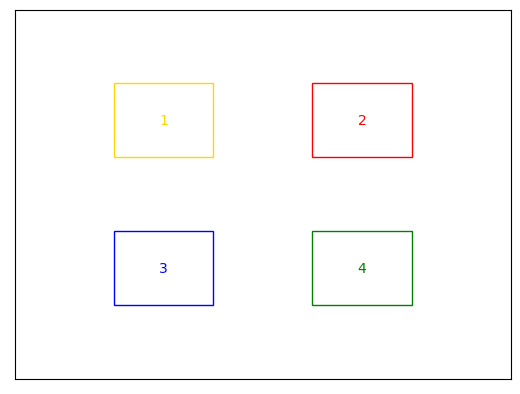

In [13]:
# Plot layout of maze
from matplotlib.patches import Rectangle

plt.figure('Maze Layout')
ax = plt.gca()
ax.set_xlim([0, 40])
ax.set_ylim([0, 40])
ax.set_xticks([])
ax.set_yticks([])
# Add maze pillars
ax.add_patch(Rectangle((8, 8), 8, 8, edgecolor='blue', fill=False, linewidth=1))
ax.add_patch(Rectangle((8, 24), 8, 8, edgecolor='gold', fill=False, linewidth=1))
ax.add_patch(Rectangle((24, 8), 8, 8, edgecolor='green', fill=False, linewidth=1))
ax.add_patch(Rectangle((24, 24), 8, 8, edgecolor='red', fill=False, linewidth=1))
# Add pillar labels
ax.text(12, 28, '1', ha='center', va='center', color='gold')
ax.text(28, 28, '2', ha='center', va='center', color='red')
ax.text(12, 12, '3', ha='center', va='center', color='blue')
ax.text(28, 12, '4', ha='center', va='center', color='green')


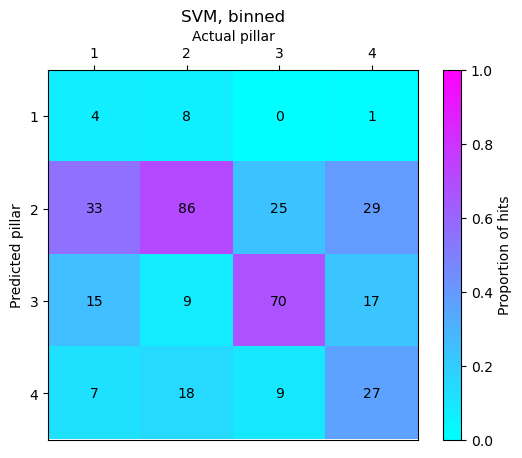

In [14]:
# Try plotting one confusion matrix
# Convert counts to proportion of predictions
conf_mat_title = 'SVM, binned'  # Select which confusion matrix to plot
conf_mat = conf_mat_dict[conf_mat_title]
num_goals = conf_mat.shape[0]
col_sums = np.sum(conf_mat, axis=0)
conf_mat_prop = np.empty_like(conf_mat)
for col, val in enumerate(col_sums):
    conf_mat_prop[:,col] = conf_mat[:,col] / val

plt.figure()
ax = plt.gca()
plt.title(conf_mat_title)
plt.imshow(conf_mat_prop, cmap='cool', vmin=0, vmax=1)
plt.colorbar(label='Proportion of hits')
plt.xticks(np.arange(num_goals), labels=np.arange(1, num_goals+1))
plt.yticks(np.arange(num_goals), labels=np.arange(1, num_goals+1))
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xlabel('Actual pillar')
plt.ylabel('Predicted pillar')
ax.xaxis.set_label_position('top')
for i, row in enumerate(conf_mat):
    for j, val in enumerate(row):
        ax.text(j, i, f'{val:.0f}', ha='center', va='center', color='k')


Text(28, 12, '4')

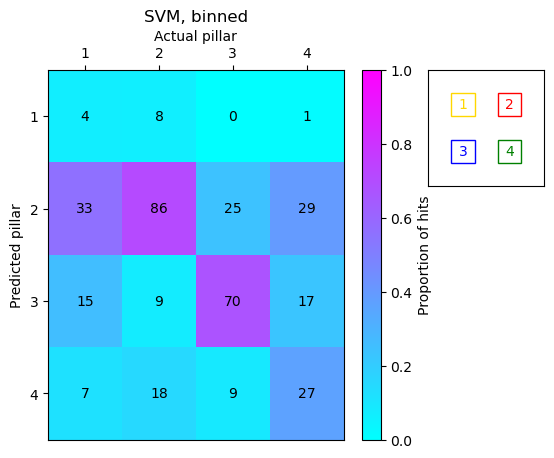

In [15]:
# Confusion matrix plot with maze layout subplot
conf_mat_title = 'SVM, binned'  # Select which confusion matrix to plot
conf_mat = conf_mat_dict[conf_mat_title]

plt.figure()
ax = plt.subplot2grid((6, 8), (0, 0), rowspan=6, colspan=6)
ax2 = plt.subplot2grid((6, 8), (0, 6), rowspan=2, colspan=2)

ax.set_title(conf_mat_title)
pcm = ax.pcolormesh(conf_mat_prop, cmap='cool', vmin=0, vmax=1)
plt.colorbar(pcm, ax=ax, label='Proportion of hits')
ax.invert_yaxis()
ax.set_xticks(np.arange(0.5, num_goals+0.5), labels=np.arange(1, num_goals+1))
ax.set_yticks(np.arange(0.5, num_goals+0.5), labels=np.arange(1, num_goals+1))
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xlabel('Actual pillar')
ax.set_ylabel('Predicted pillar')
ax.xaxis.set_label_position('top')
for i, row in enumerate(conf_mat):
    for j, val in enumerate(row):
        ax.text(j+0.5, i+0.5, f'{val:.0f}', ha='center', va='center', color='k')

ax2.set_xlim([0, 40])
ax2.set_ylim([0, 40])
ax2.set_xticks([])
ax2.set_yticks([])
# Add maze pillars
ax2.add_patch(Rectangle((8, 8), 8, 8, edgecolor='blue', fill=False, linewidth=1))
ax2.add_patch(Rectangle((8, 24), 8, 8, edgecolor='gold', fill=False, linewidth=1))
ax2.add_patch(Rectangle((24, 8), 8, 8, edgecolor='green', fill=False, linewidth=1))
ax2.add_patch(Rectangle((24, 24), 8, 8, edgecolor='red', fill=False, linewidth=1))
# Add pillar labels
ax2.text(12, 28, '1', ha='center', va='center', color='gold')
ax2.text(28, 28, '2', ha='center', va='center', color='red')
ax2.text(12, 12, '3', ha='center', va='center', color='blue')
ax2.text(28, 12, '4', ha='center', va='center', color='green')


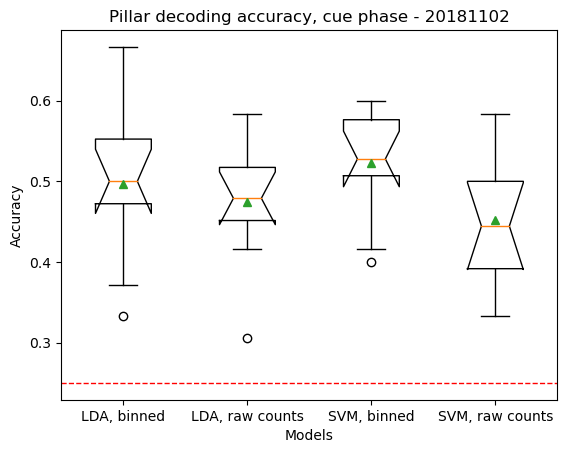

In [16]:
# Plot variance in prediciton accuracy between different models
plt.figure()
plt.title(f'Pillar decoding accuracy, cue phase - {day_dir}')
plt.boxplot(accuracy_dict.values(), showmeans=True, notch=True)
plt.axhline(y=0.25, color='r', linewidth=1, linestyle='--')
plt.xticks(np.arange(1, len(accuracy_dict)+1), labels=accuracy_dict.keys())
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()

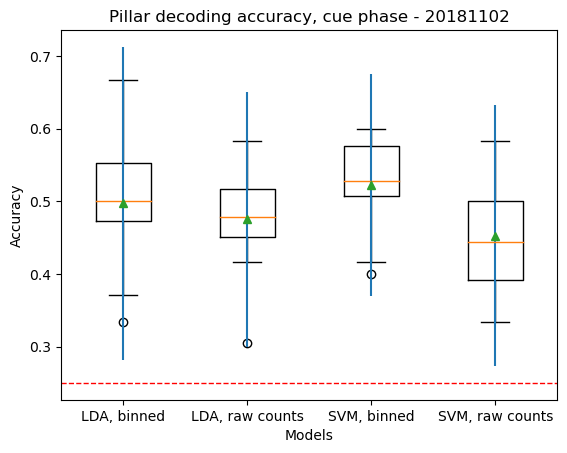

In [17]:
# Plot variance in prediciton accuracy between different models
from scipy import stats

def conf_intvl_width(data, p):
    n, mean, std = len(data), np.mean(data), np.std(data, ddof=1)
    width = std * stats.t.ppf((1 + p)/2, n-1)
    return width

accuracy_means = [np.mean(value) for value in accuracy_dict.values()]
accuracy_errs = [conf_intvl_width(value, 0.95) for value in accuracy_dict.values()]

plt.figure()
plt.title(f'Pillar decoding accuracy, cue phase - {day_dir}')
plt.boxplot(accuracy_dict.values(), showmeans=True)
plt.errorbar(np.arange(1, len(accuracy_means)+1), accuracy_means, yerr=accuracy_errs, fmt=' ')
plt.axhline(y=0.25, color='r', linewidth=1, linestyle='--')
plt.xticks(np.arange(1, len(accuracy_dict)+1), labels=accuracy_dict.keys())
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()